## Importing Required libraries

In [106]:
import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
plt.rcParams["figure.figsize"] = (7, 5)

## Loading the CTG Dataset

In [108]:
data = pd.read_csv("CTG.csv")
data.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


## Checking for Duplicate Rows

In [110]:
# Check for duplicate rows
duplicates = data[data.duplicated()]

# Print the duplicate rows (if any)
print("Duplicated rows:\n", duplicates)

# Alternatively, you can just check how many duplicates there are
num_duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Duplicated rows:
      FileName Date SegFile   b   e  LBE  LB  AC  FM  UC  ...   C   D   E  AD  \
2127      NaN  NaN     NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

      DE  LD  FS  SUSP  CLASS  NSP  
2127 NaN NaN NaN   NaN    NaN  NaN  

[1 rows x 40 columns]
Number of duplicate rows: 1


In [111]:
# Remove duplicate rows, keeping the first occurrence
data_no_duplicates = data.drop_duplicates()

# Save the cleaned dataframe to a new CSV
data_no_duplicates.to_csv('cleaned_file.csv', index=False)

data.shape

(2130, 40)

## Removing Empty Rows

In [113]:
data.isnull().sum()

FileName    4
Date        4
SegFile     4
b           4
e           4
LBE         4
LB          4
AC          4
FM          3
UC          3
ASTV        3
MSTV        3
ALTV        3
MLTV        3
DL          2
DS          2
DP          2
DR          2
Width       4
Min         4
Max         4
Nmax        4
Nzeros      4
Mode        4
Mean        4
Median      4
Variance    4
Tendency    4
A           4
B           4
C           4
D           4
E           4
AD          4
DE          4
LD          4
FS          4
SUSP        4
CLASS       4
NSP         4
dtype: int64

In [114]:
print("Original dataset shape:", data.shape)
df = data.dropna()
print("After removing rows with missing values:", df.shape)
print("Rows removed:", data.shape[0] - df.shape[0])

Original dataset shape: (2130, 40)
After removing rows with missing values: (2126, 40)
Rows removed: 4


## Remove rows there the duration of data collection is 

If the CTG data is shorter than 10 minutes:

Key signals like decelerations or abnormal variability might be missed, leading to false negatives (failing to identify distress).

Shorter data windows may also increase the likelihood of false positives, where non-distress data is flagged as problematic.

In conclusion, 10 minutes is the minimum recommended time for CTG monitoring to ensure accurate detection of fetal distress and reliable predictions for clinical decision-making. Therefore, we decided to only include data that is collected for at least 10 minutes, so that the model has more reliable data to train on.

In [116]:
short_duration_rows = df[(df['e'] - df['b']) < 600]  # Check if the duration of data collected is less than 10 mins

# Print rows with duration less than 10 minutes
print("Rows with duration less than 10 minutes:\n", short_duration_rows)

# Optional: Check how many rows have less than 10 minutes
num_short_duration = short_duration_rows.shape[0]
print(f"Number of rows with duration less than 10 minutes: {num_short_duration}")

Rows with duration less than 10 minutes:
             FileName       Date      SegFile       b       e    LBE     LB  \
1       Variab10.txt  12/1/1996  CTG0001.txt   240.0   357.0  120.0  120.0   
24       Mmmfm_1.txt   5/3/1996  CTG0024.txt   510.0   664.0  128.0  128.0   
27       Mmmfm_2.txt   5/3/1996  CTG0027.txt   280.0   477.0  124.0  124.0   
63      S0001081.dat  3/19/1996  CTG0063.txt  1255.0  1557.0  142.0  142.0   
76    S0001089_1.dat   5/2/1996  CTG0076.txt  1341.0  1852.0  154.0  154.0   
...              ...        ...          ...     ...     ...    ...    ...   
2055    S8001041.dsp   6/6/1998  CTG2057.txt  1318.0  1886.0  127.0  127.0   
2112    S8001044.dsp   6/6/1998  CTG2114.txt  1837.0  2297.0  136.0  136.0   
2114    S8001044.dsp   6/6/1998  CTG2116.txt  2252.0  2735.0  136.0  136.0   
2116    S8001045.dsp   6/6/1998  CTG2118.txt     0.0   467.0  140.0  140.0   
2117    S8001045.dsp   6/6/1998  CTG2119.txt   455.0   707.0  140.0  140.0   

       AC   FM   UC  

In [117]:
counts1 = df["NSP"].value_counts().sort_index()                     # Original dataset
counts2 = short_duration_rows["NSP"].value_counts().sort_index()    # Removed subset (less than 10 mins)
counts3 = counts1 - counts2                                         # Cleaned dataset used for training

comparison_df = pd.DataFrame({
    "Original Dataset": counts1,
    "Removed (<10 mins)": counts2,
    "After Cleaning (Used for Training)": counts3
}).fillna(0).astype(int)

comparison_df.index = comparison_df.index.map(lambda x: f"{x:.1f}")

display(
    comparison_df.style
    .set_caption("Class Distribution")
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("text-align", "center"), ("font-weight", "bold")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    .background_gradient(cmap="Pastel1", axis=None)
)

,Original Dataset,Removed (<10 mins),After Cleaning (Used for Training)
NSP,,,
1.0,1655,359,1296
2.0,295,81,214
3.0,176,46,130


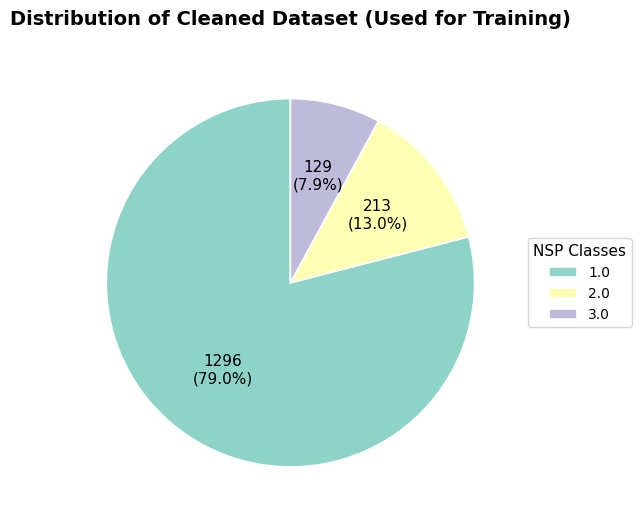

In [118]:
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{absolute}\n({pct:.1f}%)"

plt.figure(figsize=(6, 6))

colors = plt.cm.Set3(range(len(counts3)))

wedges, texts, autotexts = plt.pie(
    counts3,
    autopct=lambda pct: func(pct, counts3),
    startangle=90,
    colors=colors,
    textprops={"fontsize": 11, "color": "black"},
    wedgeprops={"edgecolor": "white", "linewidth": 1.2}
)

plt.legend(
    counts3.index,
    title="NSP Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=11
)

plt.title("Distribution of Cleaned Dataset (Used for Training)", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

In [119]:
df['duration'] = df['e'] - df['b']
df = df[df['duration'] > 600]
print(df.head())

# Check the shape of the filtered dataframe (number of rows and columns)
print(f"Shape of the dataframe after filtering: {df.shape}")

     FileName      Date      SegFile      b       e    LBE     LB   AC   FM  \
2  Fmcs_1.txt  5/3/1996  CTG0002.txt    5.0   632.0  132.0  132.0  4.0  0.0   
3  Fmcs_1.txt  5/3/1996  CTG0003.txt  177.0   779.0  133.0  133.0  2.0  0.0   
4  Fmcs_1.txt  5/3/1996  CTG0004.txt  411.0  1192.0  134.0  134.0  2.0  0.0   
5  Fmcs_1.txt  5/3/1996  CTG0005.txt  533.0  1147.0  132.0  132.0  4.0  0.0   
6  Fmcs_2.txt  5/3/1996  CTG0006.txt    0.0   953.0  134.0  134.0  1.0  0.0   

     UC  ...    D    E   AD   DE   LD   FS  SUSP  CLASS  NSP  duration  
2   4.0  ...  0.0  0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0     627.0  
3   5.0  ...  0.0  0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0     602.0  
4   6.0  ...  0.0  0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0     781.0  
5   5.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   0.0    2.0  1.0     614.0  
6  10.0  ...  0.0  0.0  0.0  0.0  1.0  0.0   0.0    8.0  3.0     953.0  

[5 rows x 41 columns]
Shape of the dataframe after filtering: (1638, 41)


## Understanding the Dataset Better

In [121]:
print(df.groupby('NSP').count())

     FileName  Date  SegFile     b     e   LBE    LB    AC    FM    UC  ...  \
NSP                                                                     ...   
1.0      1295  1295     1295  1295  1295  1295  1295  1295  1295  1295  ...   
2.0       213   213      213   213   213   213   213   213   213   213  ...   
3.0       130   130      130   130   130   130   130   130   130   130  ...   

        C     D     E    AD    DE    LD    FS  SUSP  CLASS  duration  
NSP                                                                   
1.0  1295  1295  1295  1295  1295  1295  1295  1295   1295      1295  
2.0   213   213   213   213   213   213   213   213    213       213  
3.0   130   130   130   130   130   130   130   130    130       130  

[3 rows x 40 columns]


### Non-essential Columns: 
Based on medical considerations and model training efficiency, drop the following: 
- Non-Numeric Data
- Time Instants in seconds (b, e) 
- LBE --> Used as reference only, not useful for analysis 
- DR  --> Repetitive decelerations, not useful for analysis

In [123]:
drop_cols = ["FileName", "SegFile", "Date", "b", "e", "LBE", "DR", ]
drop_cols = [c for c in drop_cols if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
df.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS',
       'SUSP', 'CLASS', 'NSP', 'duration'],
      dtype='object')

## Visulizing data on a Histogram

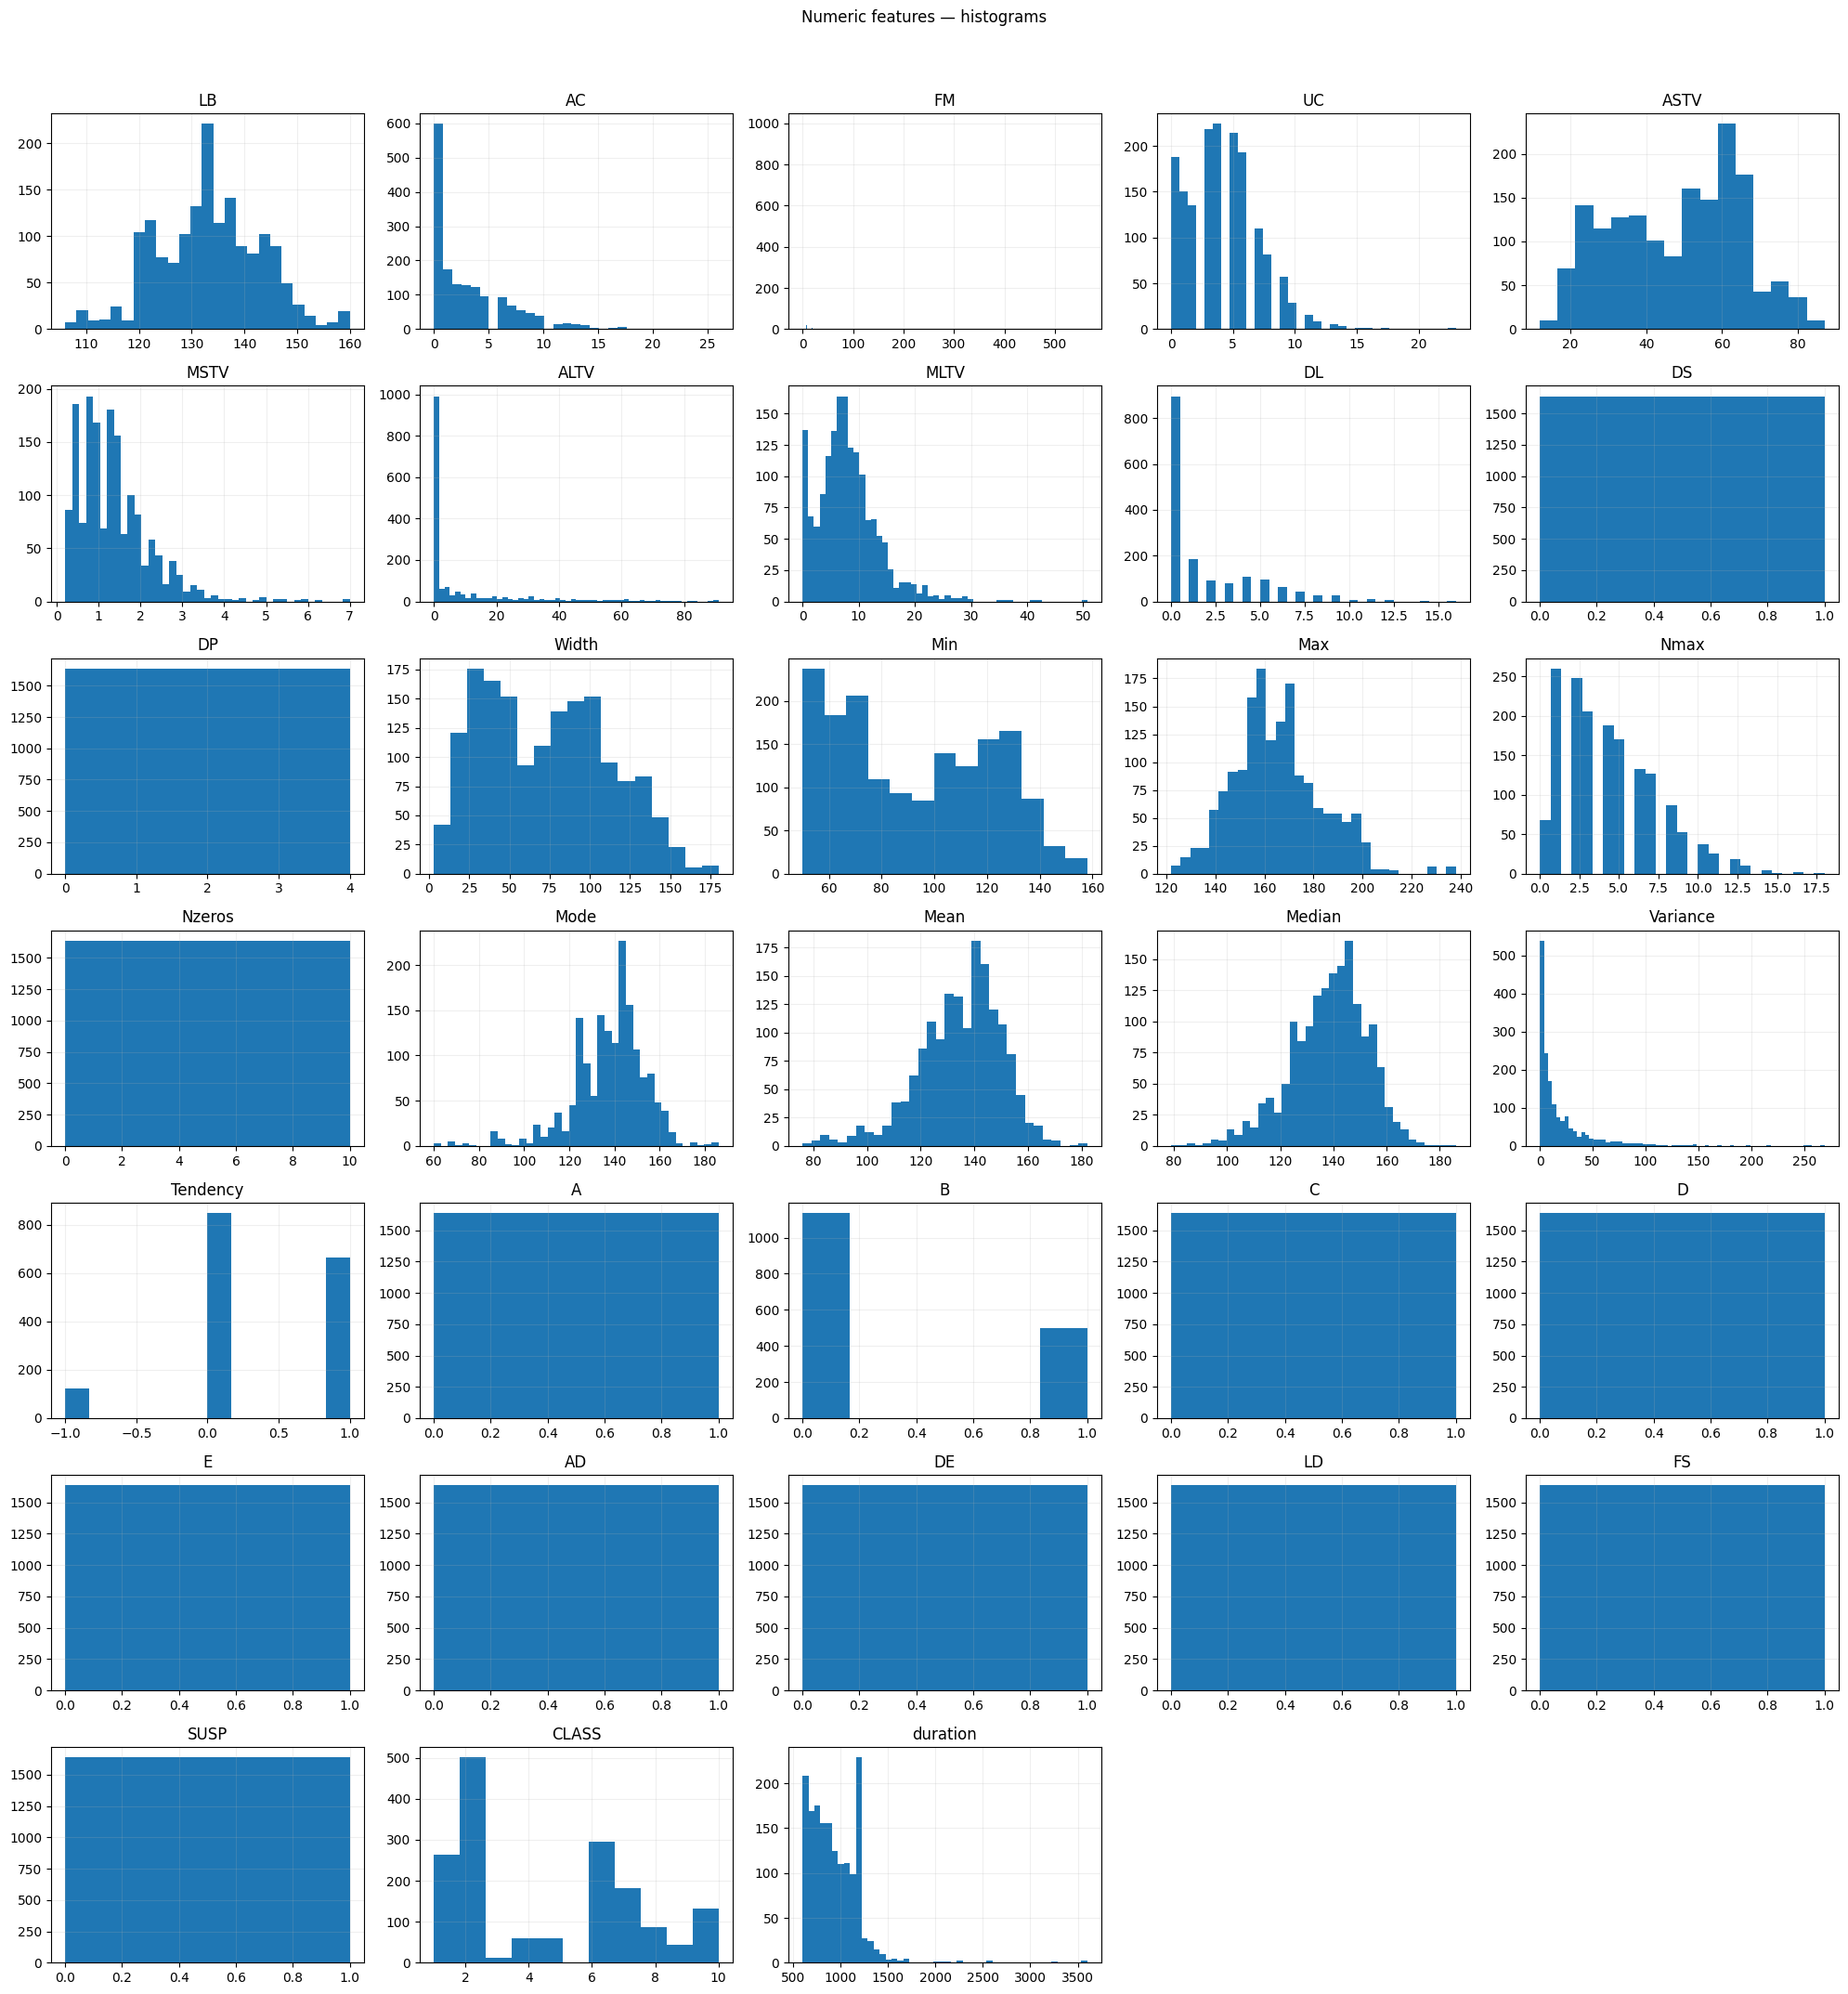

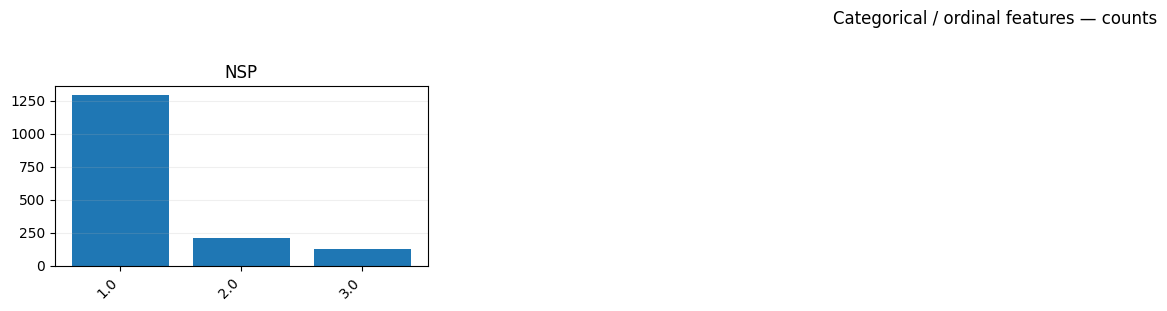

In [125]:
def plot_all_histograms(df: pd.DataFrame, ncols: int = 4, bins: str | int = "fd",
                        exclude: list[str] = None, rotate_xticks: bool = True):

    exclude = exclude or []
    cols = [c for c in df.columns if c not in exclude]

    # Separate by dtype; treat NSP specially (ordinal encoded as numbers)
    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in cols if c not in num_cols]
    if "NSP" in num_cols:   # show as categorical counts for clarity
        num_cols.remove("NSP")
        cat_cols.append("NSP")

    # ---- Numeric histograms ----
    if num_cols:
        n = len(num_cols)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(num_cols):
            ax = axes[i]
            data = df[col].dropna()
            ax.hist(data, bins=bins)
            ax.set_title(col)
            ax.grid(alpha=0.2)
        for j in range(i+1, len(axes)):  # hide unused slots
            axes[j].set_visible(False)
        fig.suptitle("Numeric features — histograms", y=1.02, fontsize=12)
        fig.tight_layout()
        plt.show()

    # ---- Categorical/ordinal counts (incl. NSP) ----
    if cat_cols:
        n = len(cat_cols)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(cat_cols):
            ax = axes[i]
            counts = df[col].astype("category").value_counts(dropna=False).sort_index()
            ax.bar([str(x) for x in counts.index], counts.values)
            ax.set_title(col)
            if rotate_xticks:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(45)
                    tick.set_ha("right")
            ax.grid(axis="y", alpha=0.2)
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        fig.suptitle("Categorical / ordinal features — counts", y=1.02, fontsize=12)
        fig.tight_layout()
        plt.show()
        
        
plot_all_histograms(df, ncols=5, bins="fd")

## After Histogram Analysis: 

We noticed that more of the columns can be removed because they do not add any value to the training data.  

In [127]:
exclude_cols = ["Min","Max", "NMax", "Nzeros", "CLASS", "SUSP", "FS", "Nmax", "A", "B", "C", "D", "E", "AD", "DE", "LD", "duration"]  # drop any that don’t exist
exclude_cols = [c for c in exclude_cols if c in df.columns]
if exclude_cols:
    df1 = df.drop(columns=exclude_cols)
df1.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')

## Understanding the correlation between different features

### Spearman correlation

Spearman works with ranks and is fine for ordinal data.

It checks whether higher NSP values (e.g., going from Normal → Suspicious → Pathological) are associated with increases/decreases in your numerical features.

## Correlation between ASTV/ALTV and Width/Variance


In [131]:
spearman_corr = df1.corr(method="spearman")["NSP"].drop("NSP")
print(spearman_corr)

LB          0.194811
AC         -0.482260
FM          0.053254
UC         -0.214189
ASTV        0.450859
MSTV       -0.244545
ALTV        0.364997
MLTV       -0.169244
DL         -0.031122
DS          0.121449
DP          0.358879
Width      -0.116466
Mode       -0.019963
Mean       -0.004053
Median     -0.022303
Variance   -0.135543
Tendency   -0.064330
Name: NSP, dtype: float64


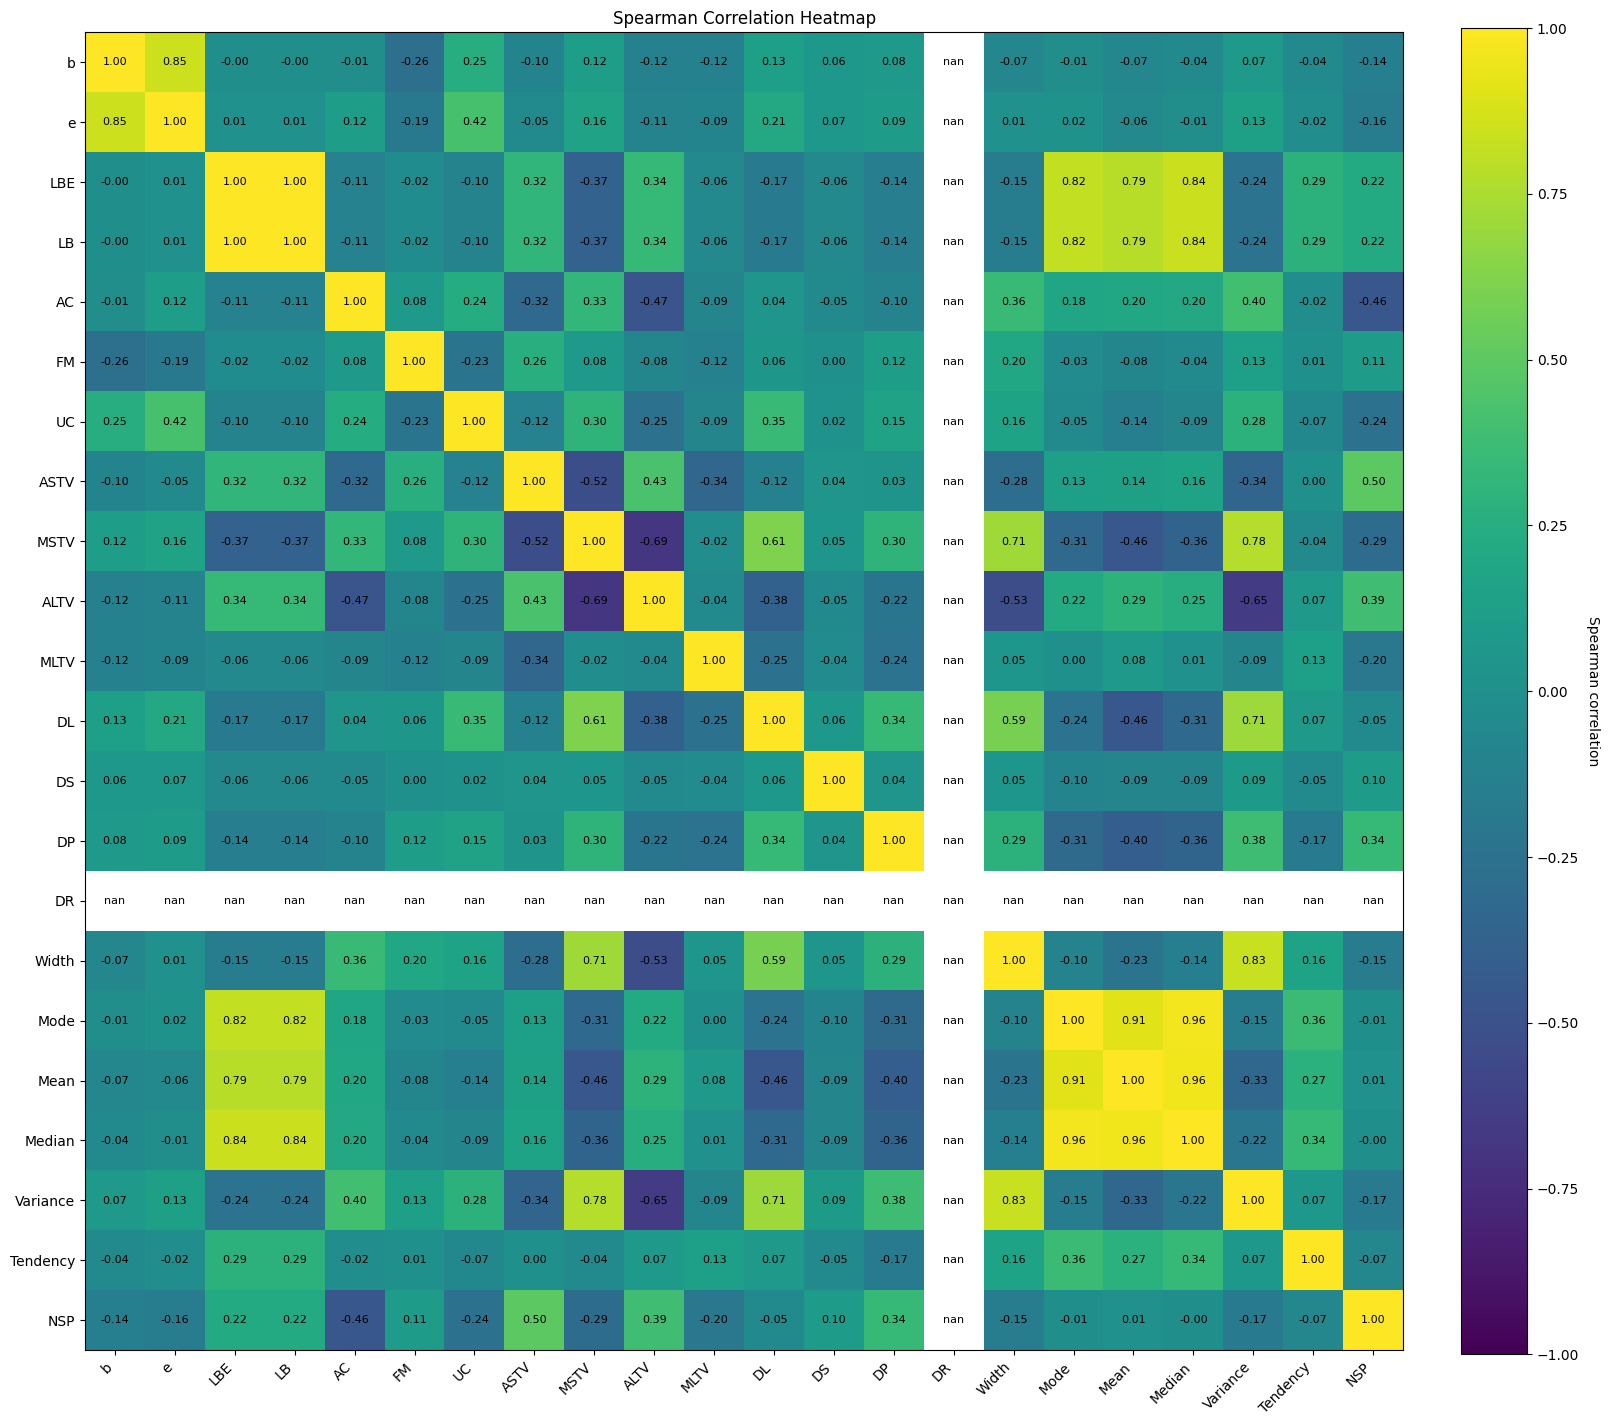

In [84]:
# Keep only numeric columns (so NSP is included)
df_num = df1.select_dtypes(include="number")

# Spearman correlation (good for ordinal NSP)
corr = df_num.corr(method="spearman")

# Plot Heatmap
fig, ax = plt.subplots(figsize=(0.6*len(corr.columns)+3, 0.6*len(corr.columns)+3))

im = ax.imshow(corr.values, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman correlation", rotation=270, labelpad=15)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

In [85]:
df2 = df[["ASTV", "MSTV", "ALTV", "MLTV", "Width", "Variance"]].copy()

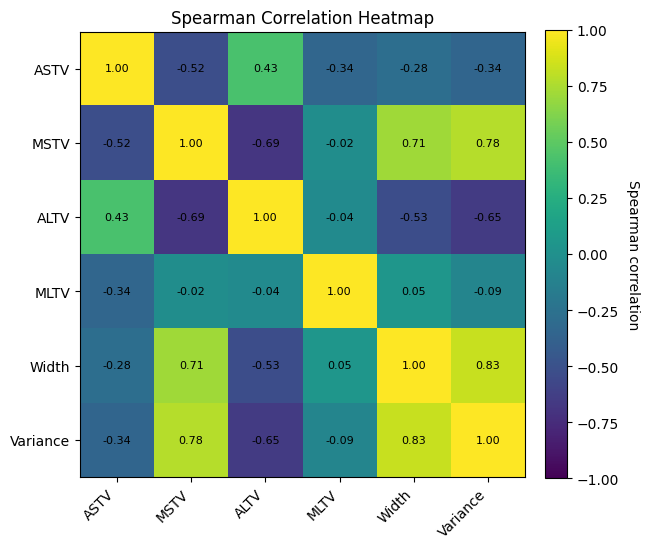

In [86]:
# Keep only numeric columns (so NSP is included)
df_num = df2.select_dtypes(include="number")

# Spearman correlation (good for ordinal NSP)
corr = df_num.corr(method="spearman")

fig, ax = plt.subplots(figsize=(0.6*len(corr.columns)+3, 0.6*len(corr.columns)+3))

im = ax.imshow(corr.values, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman correlation", rotation=270, labelpad=15)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

In [87]:
# Import and availability check for XGBoost
try:
    from xgboost import XGBClassifier 
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# Randomness control
RANDOM_STATE = 40
np.random.seed(RANDOM_STATE)

# Making the data more aesthetic & readable
hr = lambda s: print("\n" + "="*18 + f" {s} " + "="*18)

# Data loading & Validation 
TARGET_COL = "NSP"          
DATA_PATH  = "./CTG_cleaned.csv" 
df = pd.read_csv(DATA_PATH)

In [88]:
# Setting up for training
df = df[df['NSP'].notna()]
y_str = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

# Replace NSP numbers to words for better readability
label_map = {1: "Normal", 2: "Suspect", 3: "Pathologic"}
y_enc = y_str.map(label_map)

# Print NSP counts
hr("Class Distribution")
print(y_enc.value_counts().sort_index())


================== Class Distribution ==================
NSP
Normal        1295
Pathologic     130
Suspect        213
Name: count, dtype: int64


In [89]:
# Convert NSP from [1,2,3] to [0,1,2] for ML algorithms
y_encoded = y_str - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)
print(f"Train: {len(y_train)} | Test: {len(y_test)}")

Train: 1310 | Test: 328


In [90]:
# Pipeline setup
# Categorical features are ignored as they do not contribute to model

numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)], remainder="drop")

print("Numeric features:", len(numeric_features))

Numeric features: 25


In [94]:
# Balancing class weights for imbalanced classes
classes_ = np.array(sorted(np.unique(y_train))) 
class_weights = compute_class_weight(class_weight="balanced", classes=classes_, y=y_train)
CW = {int(cls): float(w) for cls, w in zip(classes_, class_weights)}
print(CW)

{0: 0.4214929214929215, 1: 2.5686274509803924, 2: 4.198717948717949}


In [99]:
# RandomForest
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight=CW  
    ))
])

# Multinomial Logistic Regression
logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        class_weight=CW,
        random_state=RANDOM_STATE
    ))
])

# SVM (RBF) with probabilities
svm = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE))
])

# XGBoost
if XGB_AVAILABLE:
    xgb = Pipeline([
        ("prep", preprocess),
        ("clf", XGBClassifier(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="multi:softprob",
            num_class=len(classes_),
            tree_method="hist",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

In [102]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "bal_acc": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "acc": "accuracy",
}

def eval_model(name, pipe, Xtr, ytr, Xte, yte, use_sw=False):
    # Cross‑validation first
    try:
        cv_out = cross_validate(pipe, Xtr, ytr, cv=cv, scoring=scoring, n_jobs=-1)
        cv_bal_acc = float(np.nanmean(cv_out["test_bal_acc"]))
        cv_f1_macro = float(np.nanmean(cv_out["test_f1_macro"]))
        cv_acc = float(np.nanmean(cv_out["test_acc"]))
    except Exception as e:
        cv_bal_acc = np.nan; cv_f1_macro = np.nan; cv_acc = np.nan

    # Fit (with optional sample weights)
    if use_sw:
        sw = pd.Series(ytr).map(CW).values
        pipe.fit(Xtr, ytr, **{"clf__sample_weight": sw})
    else:
        pipe.fit(Xtr, ytr)

    # Test metrics
    yhat = pipe.predict(Xte)
    acc = accuracy_score(yte, yhat)
    bal = balanced_accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average="macro")

    # Convert back to original labels for reporting
    y_true_orig = yte + 1  # Convert [0,1,2] back to [1,2,3]
    y_pred_orig = yhat + 1  # Convert [0,1,2] back to [1,2,3]
    
    LABEL_ORDER = [1, 2, 3]  # Use numeric labels for classification_report
    report = classification_report(y_true_orig, y_pred_orig, labels=LABEL_ORDER, digits=4, zero_division=0)

    return {
        "model": name,
        "cv_bal_acc_mean": cv_bal_acc,
        "cv_f1_macro_mean": cv_f1_macro,
        "cv_acc_mean": cv_acc,
        "test_acc": acc,
        "test_bal_acc": bal,
        "test_f1_macro": f1m,
        "y_pred": yhat,
        "y_pred_str": y_pred_orig,  # Original scale for display
        "report": report,
    }, pipe

In [104]:
results = []
models_fitted = {}

# Model training

hr("Training RandomForest")
res_rf, fitted_rf = eval_model("RandomForest", rf, X_train, y_train, X_test, y_test, use_sw=False)
results.append(res_rf); models_fitted["RandomForest"] = fitted_rf

hr("Training Logistic Regression")
res_lr, fitted_lr = eval_model("LogReg", logreg, X_train, y_train, X_test, y_test, use_sw=False)
results.append(res_lr); models_fitted["LogReg"] = fitted_lr

hr("Training SVM (RBF)")
res_svm, fitted_svm = eval_model("SVM-RBF", svm, X_train, y_train, X_test, y_test, use_sw=False)
results.append(res_svm); models_fitted["SVM-RBF"] = fitted_svm

hr("Training XGBoost")
res_xgb, fitted_xgb = eval_model("XGB", xgb, X_train, y_train, X_test, y_test, use_sw=True)
results.append(res_xgb); models_fitted["XGB"] = fitted_xgb


# Results table (sorted by CV balanced accuracy, then test balanced accuracy)
res_tbl = pd.DataFrame([{
    "model": r["model"],
    "cv_bal_acc_mean": np.round(r["cv_bal_acc_mean"], 4),
    "cv_f1_macro_mean": np.round(r["cv_f1_macro_mean"], 4),
    "cv_acc_mean": np.round(r["cv_acc_mean"], 4),
    "test_balanced_accuracy": np.round(r["test_bal_acc"], 4),
    "test_macro_f1": np.round(r["test_f1_macro"], 4),
    "test_accuracy": np.round(r["test_acc"], 4),
} for r in results])

# Primary key: CV balanced accuracy; tiebreakers: test balanced acc, then macro‑F1
res_tbl = res_tbl.sort_values([
    "cv_bal_acc_mean", "test_balanced_accuracy", "test_macro_f1"
], ascending=[False, False, False])

hr("Results (CV-first ranking)")
print(res_tbl.to_string(index=False))

# Prediction comparison (human‑readable)
preds_df = pd.DataFrame({"y_true": y_test+1}) # Convert [0,1,2] back to [1,2,3]
for r in results:
    preds_df[r["model"]] = r["y_pred_str"]
hr("Head of prediction comparison")
print(preds_df.head())

# Save CSVs
res_tbl.to_csv("ctg_all_models_results.csv", index=False)
preds_df.to_csv("ctg_all_models_predictions.csv", index=False)
print("Saved: ctg_all_models_results.csv, ctg_all_models_predictions.csv")


================== Training RandomForest ==================

================== Training Logistic Regression ==================

================== Training SVM (RBF) ==================

================== Training XGBoost ==================

================== Results (CV-first ranking) ==================
       model  cv_bal_acc_mean  cv_f1_macro_mean  cv_acc_mean  test_balanced_accuracy  test_macro_f1  test_accuracy
         XGB           0.9079            0.9235       0.9573                  0.8996         0.9128         0.9512
     SVM-RBF           0.8857            0.8400       0.8969                  0.8610         0.8268         0.8872
RandomForest           0.8717            0.8954       0.9435                  0.8621         0.8896         0.9390
      LogReg           0.8551            0.7858       0.8740                  0.8699         0.7943         0.8689

================== Head of prediction comparison ==================
      y_true  RandomForest  LogReg  SVM-RBF  XG


================== Best model (CV-first): XGB ==================
CV_bal_acc=0.9079 | CV_f1_macro=0.9235 | Test_bal_acc=0.8996 | Test_macro_f1=0.9128 | Test_acc=0.9512
Classification report (best):
              precision    recall  f1-score   support

           1     0.9656    0.9768    0.9712       259
           2     0.8571    0.8372    0.8471        43
           3     0.9583    0.8846    0.9200        26

    accuracy                         0.9512       328
   macro avg     0.9270    0.8996    0.9128       328
weighted avg     0.9508    0.9512    0.9509       328



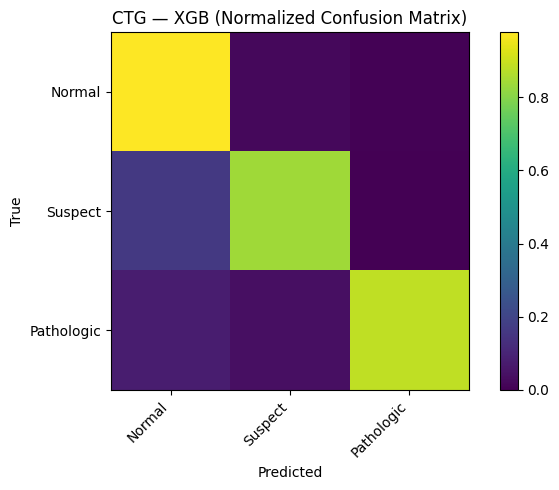

Saved best model pipeline -> ctg_best_pipeline_XGB.joblib


In [105]:
best_row = res_tbl.iloc[0]
best_name = best_row["model"]
best_pipe = models_fitted[best_name]

# Find the corresponding result dict for report/preds
best = next(r for r in results if r["model"] == best_name)

hr(f"Best model (CV-first): {best_name}")
print(
    f"CV_bal_acc={best['cv_bal_acc_mean']:.4f} | CV_f1_macro={best['cv_f1_macro_mean']:.4f} | "
    f"Test_bal_acc={best['test_bal_acc']:.4f} | Test_macro_f1={best['test_f1_macro']:.4f} | Test_acc={best['test_acc']:.4f}"
)
print("Classification report (best):")
print(best["report"])  

cm = confusion_matrix(y_test + 1, best["y_pred_str"], labels=[1, 2, 3])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(cm_norm, interpolation='nearest')
plt.title(f"CTG — {best_name} (Normalized Confusion Matrix)")
plt.colorbar()
plt.xticks(range(3), ["Normal", "Suspect", "Pathologic"], rotation=45, ha='right')
plt.yticks(range(3), ["Normal", "Suspect", "Pathologic"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Save the best pipeline
out_path = f"ctg_best_pipeline_{best_name}.joblib"
joblib.dump(best_pipe, out_path)
print(f"Saved best model pipeline -> {out_path}")